In [1]:
import numpy as np
import pandas as pd
import nltk
import random
import json
import re
import string
import itertools
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Athaya Rohadatul\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download required NLTK data
nltk.download('punkt', quiet=True)

# Initialize Sastrawi preprocessing tools
# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Create stopword remover
stop_factory = StopWordRemoverFactory()
stopword_remover = stop_factory.create_stop_word_remover()

# Get Sastrawi stopwords list
stop_words = set(stop_factory.get_stop_words())

def preprocess_text(text):
    """Text preprocessing function menggunakan Sastrawi stemmer dan stopwords"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = text.lower()                            # lowercase
    text = re.sub(r"[^\w\s]", " ", text)           # remove punctuation
    
    # Remove stopwords menggunakan Sastrawi
    text = stopword_remover.remove(text)
    
    # Stemming menggunakan Sastrawi
    stemmed = stemmer.stem(text)                   # stemming
    return stemmed.strip()


In [3]:
def load_and_preprocess_csv(csv_file_path):
    """Load CSV dan lakukan preprocessing seperti kode asli"""
    try:
        # Try different encodings
        encodings = ['utf-8', 'latin-1', 'cp1252']
        df = None
        
        for encoding in encodings:
            try:
                df = pd.read_csv(csv_file_path, encoding=encoding)
                print(f"Successfully loaded CSV with {encoding} encoding")
                break
            except UnicodeDecodeError:
                continue
        
        if df is None:
            raise ValueError("Could not load CSV with any encoding")
        
        print(f"Loaded {len(df)} rows from CSV")
        print("Columns:", df.columns.tolist())
        print("\nFirst few rows:")
        print(df.head())
        
        # Rename columns untuk konsistensi
        if 'Context' in df.columns and 'Response' in df.columns:
            df = df.rename(columns={'Context': 'pattern', 'Response': 'response'})
        elif len(df.columns) >= 2:
            # Ambil 2 kolom pertama
            df = df.rename(columns={df.columns[0]: 'pattern', df.columns[1]: 'response'})
        
        # Apply preprocessing seperti kode asli Anda
        print("Applying preprocessing...")
        df["pattern_clean"] = df["pattern"].apply(preprocess_text)
        df["response_clean"] = df["response"].apply(preprocess_text)
        
        # Remove empty rows
        df = df[(df['pattern_clean'] != '') & (df['response_clean'] != '')]
        
        print(f"After preprocessing: {len(df)} valid rows")
        print("\nSample preprocessed data:")
        print(df[["pattern", "pattern_clean", "response_clean"]].head())
        
        return df
        
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

In [4]:
def create_wordcloud(df):
    """Membuat word cloud dari patterns - seperti kode asli"""
    try:
        all_patterns = ' '.join(df['pattern_clean'].tolist())
        
        wordcloud = WordCloud(
            background_color='white', 
            max_words=100, 
            contour_width=3, 
            contour_color='steelblue'
        ).generate(all_patterns)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Patterns')
        plt.show()
        
    except Exception as e:
        print(f"Error creating wordcloud: {e}")

In [5]:
class GenerativeChatbotDataset(Dataset):
    def __init__(self, patterns_clean, responses_clean, tokenizer, max_input_length=256, max_target_length=256):
        self.patterns = patterns_clean
        self.responses = responses_clean
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.patterns)

    def __getitem__(self, idx):
        pattern = str(self.patterns[idx])
        response = str(self.responses[idx])
        
        # Format input untuk T5: menggunakan text yang sudah di-preprocess
        input_text = f"Jawab pertanyaan berikut: {pattern}"
        
        # Tokenize input
        input_encoding = self.tokenizer(
            input_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_input_length,
            return_tensors="pt"
        )
        
        # Tokenize target (response yang sudah di-preprocess)
        target_encoding = self.tokenizer(
            response,
            padding="max_length",
            truncation=True,
            max_length=self.max_target_length,
            return_tensors="pt"
        )
        
        input_ids = input_encoding.input_ids.squeeze()
        attention_mask = input_encoding.attention_mask.squeeze()
        labels = target_encoding.input_ids.squeeze()
        
        # Replace padding tokens in labels with -100
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

class GenerativeChatbot:
    def __init__(self, model_name="indonlp/cendol-mt5-small-inst"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Load tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        self.model.to(self.device)
        
        print(f"Loaded model: {model_name}")
        self.df = None
    
    def load_and_prepare_data(self, csv_file_path, show_wordcloud=True):
        """Load dan preprocess data dari CSV"""
        self.df = load_and_preprocess_csv(csv_file_path)
        
        if self.df is None:
            return False
        
        # Create word cloud jika diminta
        if show_wordcloud:
            create_wordcloud(self.df)
        
        return True
    
    def train(self, epochs=30, batch_size=16, learning_rate=2e-5, validation_split=0.1, patience=5):
        """Train the generative chatbot"""
        
        if self.df is None:
            print("Error: Data belum di-load. Gunakan load_and_prepare_data() terlebih dahulu.")
            return
        
        print(f"Training with {len(self.df)} question-answer pairs")
        
        # Gunakan data yang sudah di-preprocess
        X = self.df['pattern_clean'].tolist()
        y = self.df['response_clean'].tolist()
        
        # Split data
        train_patterns, val_patterns, train_responses, val_responses = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )
        
        print(f"Training samples: {len(train_patterns)}")
        print(f"Validation samples: {len(val_patterns)}")
        
        # Create datasets
        train_dataset = GenerativeChatbotDataset(train_patterns, train_responses, self.tokenizer)
        val_dataset = GenerativeChatbotDataset(val_patterns, val_responses, self.tokenizer)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Setup optimizer
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        
        # Training loop
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            total_train_loss = 0
            
            for batch in train_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                
                optimizer.zero_grad()
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            
            # Validation phase
            self.model.eval()
            total_val_loss = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch["input_ids"].to(self.device)
                    attention_mask = batch["attention_mask"].to(self.device)
                    labels = batch["labels"].to(self.device)
                    
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )
                    
                    total_val_loss += outputs.loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader)
            
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), "best_generative_model.pt")
                print("Model saved!")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break
        
        print("Training completed!")
    
    def generate_response(self, question, max_length=256, num_beams=4, temperature=0.7):
        """Generate response to a question"""
        self.model.eval()
        
        # Preprocess question dengan fungsi yang sama
        clean_question = preprocess_text(question)
        input_text = f"Jawab pertanyaan berikut: {clean_question}"
        
        # Tokenize input
        input_encoding = self.tokenizer(
            input_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=256
        ).to(self.device)
        
        # Generate response
        with torch.no_grad():
            generated_ids = self.model.generate(
                input_ids=input_encoding.input_ids,
                attention_mask=input_encoding.attention_mask,
                max_length=max_length,
                num_beams=num_beams,
                temperature=temperature,
                do_sample=True,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )
        
        # Decode response
        response = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return response.strip()

In [6]:
def chat(self):
        """Interactive chat interface"""
        print("=== Generative Chatbot Indonesia ===")
        print("Ketik 'quit' atau 'keluar' untuk mengakhiri chat")
        print("=====================================")
        
        while True:
            user_input = input("\nAnda: ").strip()
            
            if user_input.lower() in ['quit', 'keluar', 'exit']:
                print("Bot: Terima kasih telah menggunakan chatbot! Sampai jumpa!")
                break
            
            if not user_input:
                continue
            
            try:
                response = self.generate_response(user_input)
                print(f"Bot: {response}")
            except Exception as e:
                print(f"Bot: Maaf, terjadi kesalahan: {e}")

In [7]:
# if __name__ == "__main__":
#     # Initialize chatbot
#     chatbot = GenerativeChatbot()
    
#     # Load and preprocess data dari CSV
#     if chatbot.load_and_prepare_data("data.csv", show_wordcloud=True):
#         print("Data berhasil di-load dan di-preprocess!")
        
#         # Train the model dengan parameter yang sama seperti kode asli
#         print("Starting training...")
#         chatbot.train(epochs=30, batch_size=16, learning_rate=2e-5, patience=5)
        
#         # Load best model if training was completed
#         try:
#             chatbot.model.load_state_dict(torch.load("best_generative_model.pt"))
#             print("Loaded best model!")
#         except:
#             print("Using current model state")
        
#         # Start interactive chat
#         chatbot.chat()
#     else:
#         print("Gagal memuat data. Periksa file data.csv Anda.")


In [8]:
if __name__ == "__main__":
    chatbot = GenerativeChatbot()
    print("Chatbot berhasil diinisialisasi!")

Using device: cpu
Loaded model: indonlp/cendol-mt5-small-inst
Chatbot berhasil diinisialisasi!


Successfully loaded CSV with utf-8 encoding
Loaded 5667 rows from CSV
Columns: ['Context', 'Response']

First few rows:
                                             Context  \
0  Aku sedang melalui beberapa hal dengan perasaa...   
1  Aku sedang melalui beberapa hal dengan perasaa...   
2  Aku sedang melalui beberapa hal dengan perasaa...   
3  Aku sedang melalui beberapa hal dengan perasaa...   
4  Aku sedang melalui beberapa hal dengan perasaa...   

                                            Response  
0  Jika semua orang berpikir Anda tidak berharga,...  
1  Halo,  dan terima kasih atas pertanyaan Anda d...  
2  Hal pertama yang saya sarankan adalah mendapat...  
3  Terapi sangat penting bagi mereka yang merasa ...  
4  Pertama-tama saya ingin memberi tahu Anda bahw...  
Applying preprocessing...
After preprocessing: 5664 valid rows

Sample preprocessed data:
                                             pattern  \
0  Aku sedang melalui beberapa hal dengan perasaa...   
1  Aku seda

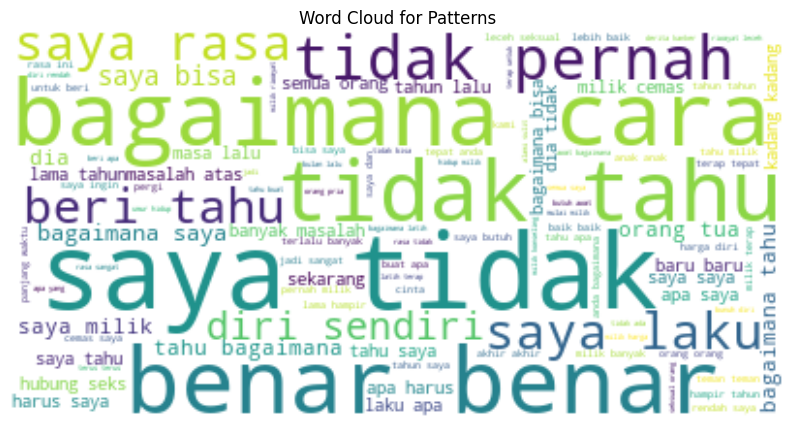

Data berhasil di-load dan di-preprocess!


In [9]:
data_loaded = chatbot.load_and_prepare_data("data.csv", show_wordcloud=True)

if data_loaded:
    print("Data berhasil di-load dan di-preprocess!")
else:
    print("Gagal memuat data. Periksa file data.csv Anda.")

In [ ]:
if data_loaded:
    print("Starting training...")
    chatbot.train(epochs=10, batch_size=16, learning_rate=2e-5, patience=5)
    print("Training selesai!")
else:
    print("Tidak bisa melakukan training karena data tidak berhasil dimuat.")

In [ ]:
if data_loaded:
    try:
        chatbot.model.load_state_dict(torch.load("best_generative_model.pt"))
        print("Loaded best model!")
    except Exception as e:
        print(f"Tidak bisa load best model: {e}")
        print("Using current model state")
else:
    print("Tidak bisa load model karena data tidak berhasil dimuat.")

In [ ]:
if data_loaded:
    print("Memulai interactive chat...")
    chatbot.chat()
else:
    print("Tidak bisa memulai chat karena data tidak berhasil dimuat.")